In [90]:
from torchvision import utils
from basic_fcn import *
from dataloader import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

In [54]:
batch = 5
train_dataset = CityScapesDataset(csv_file='train.csv')
val_dataset = CityScapesDataset(csv_file='val.csv')
test_dataset = CityScapesDataset(csv_file='test.csv')
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch,
                          num_workers=4,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=batch,
                          num_workers=4,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch,
                          num_workers=4,
                          shuffle=True)

In [40]:
# Inspect DataLoader objects
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 2975
Number of validation examples: 500
Number of test examples: 1525


In [48]:
# Look at a dataset data
example = train_dataset[0]
print("Training set example image file:", train_dataset.data.iloc[0][0])
print("Training set example label file:", train_dataset.data.iloc[0][1])
print("Size of the image tensor:", example[0].size())
print("Size of the one-hot target tensor:", example[1].size())
print("Size of the label tensor:", example[2].size())
print(example[2])

Training set example image file: /datasets/cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png
Training set example label file: /datasets/cityscapes/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png
Size of the image tensor: torch.Size([3, 1024, 2048])
Size of the one-hot target tensor: torch.Size([34, 1024, 2048])
Size of the label tensor: torch.Size([1024, 2048])
tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])


In [100]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.xavier_uniform_(m.bias.data.unsqueeze(0)) #add unsqueeze here 
        
epochs     = 10
criterion = nn.CrossEntropyLoss()
fcn_model = FCN(n_class=n_class)
fcn_model.apply(init_weights)
#fcn_model = torch.load('best_model')
optimizer = optim.Adam(fcn_model.parameters(), lr=5e-3)

In [ ]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    fcn_model = fcn_model.cuda()
    
def train():
    t_losses = []
    t_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(1, epochs+1):
        print("Training Epoch {}".format(epoch))
        ts = time.time()
        
        numIter = 0
        epoch_train_loss = 0
        epoch_train_acc = 0
        
        for iter, (X, tar, Y) in enumerate(train_loader):
            numIter +=1
            optimizer.zero_grad()

            if use_gpu:
                inputs = X.cuda() # Move your inputs onto the gpu
                labels = Y.cuda()
                oneHotLabels = tar.cuda()
            else:
                inputs, oneHotLabels, labels = X, tar, Y # Unpack variables into inputs and labels

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item()
            
            speakSoftlyAndCarryABigStick = F.softmax(outputs, dim = 1) #softmax along the number of class dimension
            indexes = torch.argmax(speakSoftlyAndCarryABigStick, dim = 1) #get the argmax along the channel dimension
            epoch_train_acc += pixel_acc(indexes, labels) 
            
            loss.backward()
            optimizer.step()

            if iter % 100 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item()))
            '''
            if iter == 100:
                break
            '''
            
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        del inputs, oneHotLabels, outputs, loss, indexes, speakSoftlyAndCarryABigStick
        torch.cuda.empty_cache()     
        #torch.save(fcn_model, 'best_model')
        print()
        
        t_losses.append(epoch_train_loss/numIter)
        t_accuracies.append(epoch_train_acc/numIter)
        
        val_loss, val_acc = val(epoch)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        fcn_model.train()
    return t_losses, t_accuracies, val_losses, val_accuracies

def val(epoch):
    print("Validation Epoch {}".format(epoch))
    fcn_model.eval()
    #Complete this function - Calculate loss, accuracy and IoU for every epoch
    valLoss = 0
    valAcc = 0
    numIter = 0
    ts = time.time()
    for iter, (X, tar, Y) in enumerate(val_loader):
            numIter +=1
            if use_gpu:
                torch.cuda.empty_cache() 
                inputs = X.cuda() # Move your inputs onto the gpu
                labels = Y.cuda()
                oneHotLabels = tar.cuda()
            else:
                inputs, oneHotLabels, labels = X, tar, Y # Unpack variables into inputs and labels
            
            outputs = fcn_model(inputs)
            valLoss += criterion(outputs, labels).item()   
            
            speakSoftlyAndCarryABigStick = F.softmax(outputs, dim = 1) #softmax along the number of class dimension
            indexes = torch.argmax(speakSoftlyAndCarryABigStick, dim = 1) #get the argmax along the channel dimension
            goGoGadgetSkis = torch.zeros_like(oneHotLabels).scatter(1, indexes.unsqueeze(1), 1.0) #transform into one-hot encoding
            
            '''
            #Only use for one batch
            
            print("Model output size (not one-hot encoded):", indexes.size())
            print(indexes)
            print("Original label size (not one-hot encoded):", labels.size())
            print(labels)
            print()
            print("Model output size for channel 30 (one-hot encoded):", goGoGadgetSkis.size())
            print(goGoGadgetSkis[0][30])
            print("Original label size for channel 30 (one-hot encoded):", oneHotLabels.size())
            print(oneHotLabels[0][30])
            print()
            '''

            valAcc += pixel_acc(indexes, labels)        
            
            #manage memory again...
            del inputs, oneHotLabels, outputs, indexes, goGoGadgetSkis, speakSoftlyAndCarryABigStick
            torch.cuda.empty_cache()            
            
            '''
            if iter == 20:
                break
            '''
            
    valAcc = valAcc/numIter
    valLoss = valLoss/numIter
    print("epoch{}, validation loss: {}".format(epoch, valLoss))
    print("epoch{}, validation accuracy: {}".format(epoch, valAcc))
    print("Finish validation at epoch{}, time elapsed {}".format(epoch, time.time() - ts))
    print()
    return valLoss, valAcc
    
def test():
    #Complete this function - Calculate accuracy and IoU 
    # Make sure to include a softmax after the output from your model
    speakSoftlyAndCarryABigStick = F.softmax(outputs, dim = 1)
    
if __name__ == "__main__":
    val(0)  # show the accuracy before training
    training_losses, training_accuracies, validation_losses, validation_accuracies = train()

Validation Epoch 0


In [103]:
print(training_losses)
print(validation_losses)
print(validation_accuracies)

[2.105125607830463, 1.7019034246406932]
[2.027135905765352, 1.668653754960923]
[40.92789150419689, 48.4917300088065]


Text(0.5, 1.0, 'Loss on training set and holdout set vs. number of epochs of gradient descent')

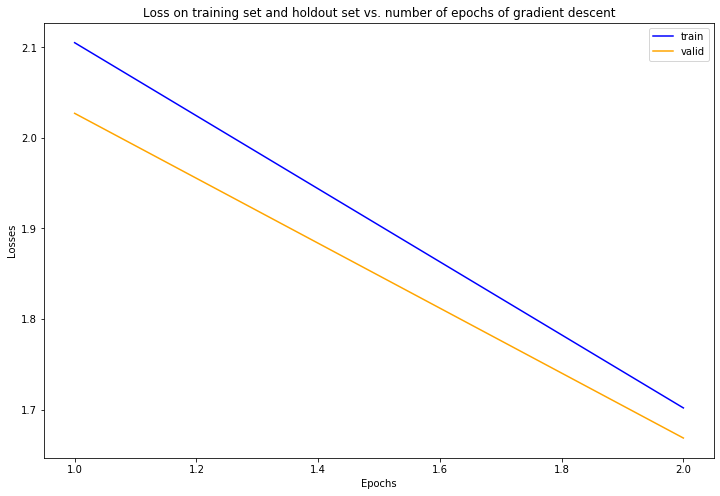

In [108]:
fig,ax = plt.subplots(figsize=(12,8))
ax.set_ylabel('Losses')
ax.set_xlabel('Epochs')
_=ax.plot(range(1, epochs+1), training_losses,'b-',color="blue",label="train")
_=ax.plot(range(1, epochs+1), validation_losses,'b-',color="orange",label="valid")
plt.legend()
plt.title("Loss on training set and holdout set vs. number of epochs")

Text(0.5, 1.0, 'Loss on training set and holdout set vs. number of epochs of gradient descent')

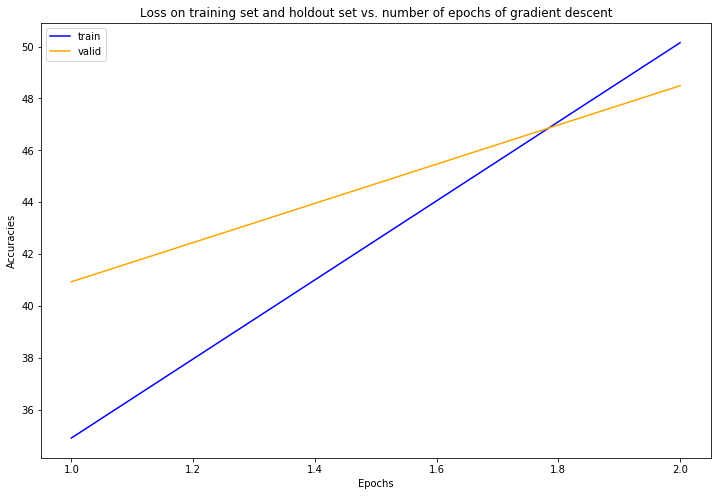

In [109]:
fig,ax = plt.subplots(figsize=(12,8))
ax.set_ylabel('Accuracies')
ax.set_xlabel('Epochs')
_=ax.plot(range(1, epochs+1), training_accuracies,'b-',color="blue",label="train")
_=ax.plot(range(1, epochs+1), validation_accuracies,'b-',color="orange",label="valid")
plt.legend()
plt.title("Loss on training set and holdout set vs. number of epochs")